In [99]:
#Libraries to dynamically get datasets
from yahoofinancials import YahooFinancials
import yfinance as yf
from pytrends.request import TrendReq

#Data manipulation and math libraries
import pandas as pd
import numpy as np
import talib
from datetime import date, timedelta
import datetime

#Plotting library
import matplotlib.pyplot as plt

#Machine Learning libraries
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

import warnings

In [100]:
#Setup stock initial variables
stock_ticker = "AMD"
features = ['Close','Volume']

In [101]:
#Get stock data
ticker = yf.Ticker(stock_ticker)
stock = ticker.history(period="max")[features]
stock.columns = ['close_stock','volume_stock']

#Get SP500 data and merge with stock data
ticker = yf.Ticker("^GSPC")
sp500 = ticker.history(period="max")[features].reindex(stock.index)
sp500.columns = ['close_sp500','volume_sp500']
df = pd.concat([stock,sp500],axis=1)

#Get M2 data and merge with stock data
m2 = pd.read_csv('M2SL.csv',parse_dates=['DATE'],index_col='DATE')
m2 = m2.reindex(df.index).ffill()
m2.columns = ['m2_supply']
df = pd.concat([df,m2],axis=1)

#Get rates data and merge with stock data
rates = pd.read_csv('FEDFUNDS.csv',parse_dates=['DATE'],index_col='DATE')
rates = rates.reindex(df.index).ffill()
rates.columns = ['fed_rate']
df = pd.concat([df,rates],axis=1)

#Get google trends and merge with stock data
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = [stock_ticker]
pytrends.build_payload(kw_list, cat=0,timeframe='all')
trends = pytrends.interest_over_time().iloc[:,0]
trends.name = 'google_trend'
trends = trends.reindex(pd.date_range(start=trends.index[0],end=date.today())).interpolate()
trends = trends.reindex(df.index)
df = pd.concat([df,trends],axis=1)

#Inspect last 5 rows of raw data
df.tail()

,close_stock,volume_stock,close_sp500,volume_sp500,m2_supply,fed_rate,google_trend
Date,,,,,,,
2021-11-22,152.520004,58674100,4682.939941,3206280000,20982.9,0.08,53.0
2021-11-23,149.919998,62852700,4690.700195,3428780000,20982.9,0.08,53.0
2021-11-24,157.800003,60677100,4701.459961,2464040000,20982.9,0.08,53.0
2021-11-26,154.809998,36245100,4594.620117,2676740000,20982.9,0.08,53.0
2021-11-29,161.910004,57139174,4655.270020,2497291000,20982.9,0.08,53.0


In [102]:
#Setup time variables
last_train_day = df.index[-3].strftime('%Y-%m-%d')
day_used_to_predict = df.index[-2].strftime('%Y-%m-%d')
day_to_predict = df.index[-1].strftime('%Y-%m-%d')

## Exploratory Data Analysis

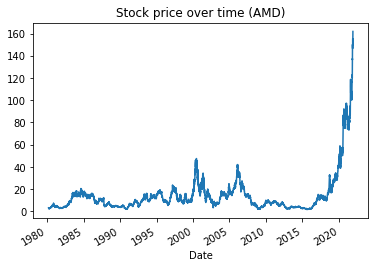

In [103]:
#Generate plot for EDA
#plt.rcParams['figure.figsize'] = [20, 10]
df['close_stock'].plot()
plt.title('Stock price over time ({})'.format(stock_ticker))
plt.show()

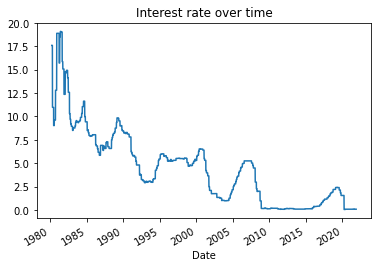

In [104]:
#Generate plot for EDA
#plt.rcParams['figure.figsize'] = [20, 10]
df['fed_rate'].plot()
plt.title('Interest rate over time')
plt.show()

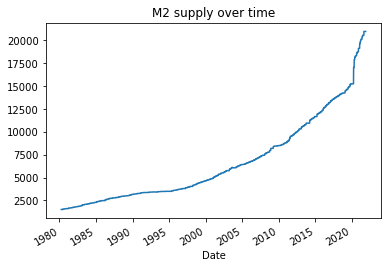

In [105]:
#Generate plot for EDA
#plt.rcParams['figure.figsize'] = [20, 10]
df['m2_supply'].plot()
plt.title('M2 supply over time')
plt.show()

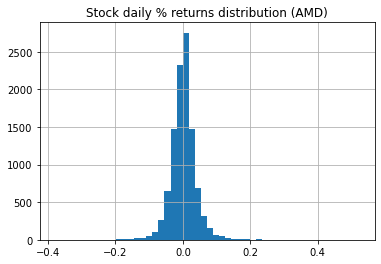

In [106]:
#Generate plot for EDA
df['close_stock'].pct_change().hist(bins=50)
#plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Stock daily % returns distribution ({})'.format(stock_ticker))
plt.show()

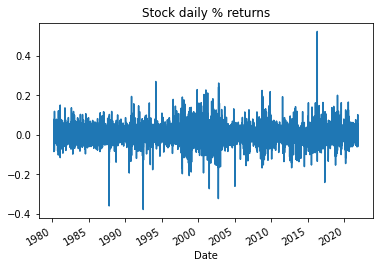

In [107]:
#plt.rcParams['figure.figsize'] = [20, 10]
df['close_stock'].pct_change().plot()
plt.title('Stock daily % returns')
plt.show()

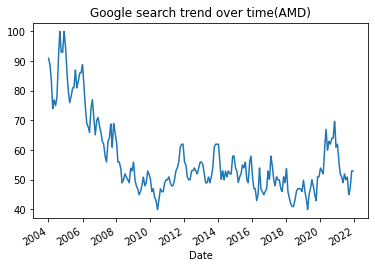

In [108]:
#plt.rcParams['figure.figsize'] = [20, 10]
df['google_trend'].plot()
plt.title('Google search trend over time({})'.format(stock_ticker))
plt.show()

## Feature Engineering

In [109]:
#Generate RSI and MA for close_stock field for multiple periods
for n in [14,30,50,200]:
    # Normalize MA for better perfomance
    df['ma' + str(n)] = talib.SMA(df['close_stock'].values,timeperiod=n) / df['close_stock']
    # Create the RSI indicator
    df['rsi' + str(n)] = talib.RSI(df['close_stock'].values, timeperiod=n)
    
#Generate stock percentage change
df['volume_stock_pct_change_1d'] = df['volume_stock'].pct_change()

#Generate target variable stock return change (next_day_pct_change)
df['next_day_pct_change'] = df['close_stock'].shift(-1).pct_change()

#Generate boolean value wether the last change in stock return was positive
df['last_positive'] = df['next_day_pct_change'].shift(1) > 0

#Actual change up to the current time
actual_change = (df.loc[day_used_to_predict,['next_day_pct_change']] * 100).values[0]



In [110]:
#days_of_week = pd.get_dummies(hist.index.dayofweek,drop_first=True)
#days_of_week.columns = ['Tuesday','Wednesday','Thursday','Friday']
#days_of_week.index = hist.index
#hist = pd.concat([hist,days_of_week],axis=1)
#days_of_week.head()
#start_period
df.tail()


,close_stock,volume_stock,close_sp500,volume_sp500,m2_supply,fed_rate,google_trend,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,volume_stock_pct_change_1d,next_day_pct_change,last_positive
Date,,,,,,,,,,,,,,,,,,
2021-11-22,152.520004,58674100,4682.939941,3206280000,20982.9,0.08,53.0,0.960272,70.002664,0.860844,69.157429,0.789191,66.762838,0.631906,59.349435,0.409304,-0.017047,False
2021-11-23,149.919998,62852700,4690.700195,3428780000,20982.9,0.08,53.0,0.986164,65.739192,0.885752,66.854328,0.808773,65.260651,0.644833,58.911592,0.071217,0.052561,False
2021-11-24,157.800003,60677100,4701.459961,2464040000,20982.9,0.08,53.0,0.946107,71.420412,0.851796,69.987940,0.775001,67.520720,0.614706,59.814615,-0.034614,-0.018948,True
2021-11-26,154.809998,36245100,4594.620117,2676740000,20982.9,0.08,53.0,0.972902,66.888068,0.877467,67.483644,0.796247,65.861697,0.628586,59.317469,-0.402656,0.045863,False
2021-11-29,161.910004,57139174,4655.270020,2497291000,20982.9,0.08,53.0,0.935423,71.511290,0.849239,70.110805,0.768499,67.779935,0.603125,60.108728,0.576466,0.000000,True


## Machine Learning

In [111]:
#Generate X matrix and y vector for ML models, from start_period
start_period = '2016-01-01'
#Remove missing values and slice from start period
df = df.dropna()[start_period:] 
X = df.drop(['next_day_pct_change'],axis=1)
y = df['next_day_pct_change']
#Initialize an array in which we will save the predictions
predictions = np.array([]) 

In [112]:
#Define function to create sets
def get_train_test_sets(X,y,knn=False): 
    scaler = StandardScaler() 
    X_train = X[:last_train_day]    
    if knn is True:
        X_train = scaler.fit_transform(X_train)
    y_train = y[:last_train_day]        
    X_used_to_predict = pd.DataFrame(df.drop(['next_day_pct_change'],axis=1).loc[day_used_to_predict]).transpose()    
    #KNN algorithm requires the data to be scaled
    if knn is True:
        X_used_to_predict = scaler.transform(X_used_to_predict)
    return  X_train,y_train,X_used_to_predict

#Define function to train and evaluate models, and return the prediction for next day stock price
def train_and_evaluate(model,X,y,knn=False):
    X_train, y_train,X_used_to_predict = get_train_test_sets(X,y,knn=knn)    
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)    
    y_day_to_predict_pred = model.predict(X_used_to_predict)    
    print('R2 score for training set: ' + str(r2_score(y_train,y_train_pred)))    
    print('Prediction % change for stock '+stock_ticker + ' ' +\
      day_to_predict+ \
      ' is: {:.2f}'.format(y_day_to_predict_pred[0]*100))    
    if knn is False:
        plot_feature_importances(model)
    return y_day_to_predict_pred[0]*100
    
#Define function to plot feature importances
def plot_feature_importances(model):    
    importances = model.feature_importances_    
    sorted_index = np.argsort(importances)[::-1]
    x = range(len(importances))    
    labels = np.array(model.feature_names_in_)[sorted_index]
    plt.bar(x, importances[sorted_index], tick_label=labels)    
    plt.xticks(rotation=90)
    plt.show()

R2 score for training set: 0.8394262325152764
Prediction % change for stock AMD 2021-11-29 is: 1.56


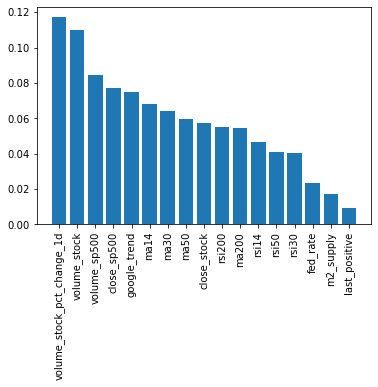

In [113]:
#Train and evaluate Random Forest
random_forest = RandomForestRegressor(random_state=100)
pred = train_and_evaluate(random_forest,X,y)
predictions = np.append(predictions,pred)

R2 score for training set: 0.07231907769163715
Prediction % change for stock AMD 2021-11-29 is: 0.36


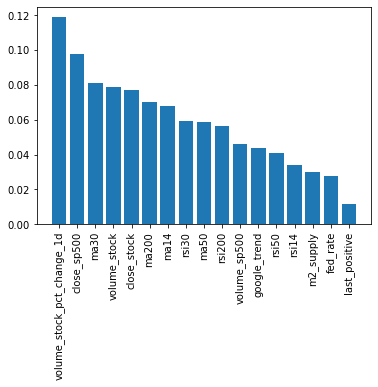

In [114]:
#Train and evaluate Gradient Boosting
gbr = GradientBoostingRegressor(max_features=3,
                                learning_rate=0.01,
                                n_estimators=100,                                
                                subsample=0.6,
                                random_state=100)
pred = train_and_evaluate(gbr,X,y)
predictions = np.append(predictions,pred)

In [115]:
#Train and evaluate KNN
knn = KNeighborsRegressor(n_neighbors=3)
pred = train_and_evaluate(knn,X,y,knn=True)
predictions = np.append(predictions,pred)

R2 score for training set: 0.328493013706569
Prediction % change for stock AMD 2021-11-29 is: 3.92


In [116]:
from statsmodels.tsa.stattools import adfuller
# Compute and print ADF p-value
result = adfuller(df['close_stock'])
print("The p-value for the ADF test is ", result[1])

The p-value for the ADF test is  1.0


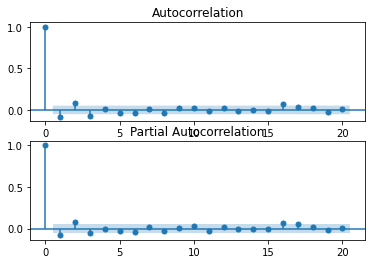

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
diff = pd.DataFrame(df['close_stock'].pct_change()).dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(diff, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(diff, lags=20, ax=axes[1])
plt.show()

In [118]:
warnings.filterwarnings('ignore')
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(diff, order=(1, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARMA(diff, order=(2, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARMA(diff,order=(1,1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

The AIC for an AR(1) is:  -5430.37931833749
The AIC for an AR(2) is:  -5436.752154585539
The AIC for an ARMA(1,1) is:  -5438.862136376713


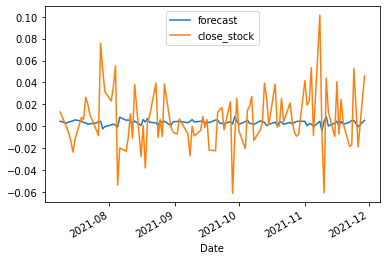

In [119]:
res_ar1.plot_predict(start=len(diff)-100)
plt.show()

In [120]:
#Print AR(1) prediction
prediction = res_ar1.predict(start=len(diff)-1,end=len(diff)).iloc[1] * 100
print('AR(1) prediction change for stock '+stock_ticker + ' ' +\
      day_to_predict+ \
      ' is: {:.2f}%'.format(prediction))

#Print Random Forest prediction
print('Random Forest prediction change for stock '+stock_ticker + ' ' +\
      day_to_predict+ \
      ' is: {:.2f}%'.format(predictions[0]))

#Print Gradient Boosting prediction
print('Gradient Boosting prediction change for stock '+stock_ticker + ' ' +\
      day_to_predict+ \
      ' is: {:.2f}%'.format(predictions[1]))

#Print KNN prediction
print('KNN prediction change for stock '+stock_ticker + ' ' +\
      day_to_predict+ \
      ' is: {:.2f}%'.format(predictions[2]))

#Print actual change
print('\nActual prediction change of day {} up to this moment is {:.2f}%'.format(day_to_predict,actual_change))

AR(1) prediction change for stock AMD 2021-11-29 is: 0.00%
Random Forest prediction change for stock AMD 2021-11-29 is: 1.56%
Gradient Boosting prediction change for stock AMD 2021-11-29 is: 0.36%
KNN prediction change for stock AMD 2021-11-29 is: 3.92%

Actual prediction change of day 2021-11-29 up to this moment is 4.59%


In [121]:
df.tail(10)

,close_stock,volume_stock,close_sp500,volume_sp500,m2_supply,fed_rate,google_trend,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,volume_stock_pct_change_1d,next_day_pct_change,last_positive
Date,,,,,,,,,,,,,,,,,,
2021-11-15,146.490005,52271300,4682.799805,2618980000,20982.9,0.08,53.0,0.926558,70.815752,0.840508,69.019435,0.789556,66.270307,0.646900,58.861089,0.002822,0.040685,False
2021-11-16,152.449997,53100800,4700.899902,2838210000,20982.9,0.08,53.0,0.904470,74.421930,0.818721,71.310688,0.764369,67.996644,0.623695,59.560563,0.015869,-0.007281,True
2021-11-17,151.339996,54527500,4688.669922,3221250000,20982.9,0.08,53.0,0.925348,72.622107,0.835232,70.308857,0.775944,67.341633,0.630366,59.371611,0.026868,0.024316,False
2021-11-18,155.020004,60612700,4704.540039,3335620000,20982.9,0.08,53.0,0.919411,74.798169,0.825848,71.673688,0.763829,68.372323,0.617569,59.796582,0.111599,0.002516,True
2021-11-19,155.410004,41633400,4697.959961,3265600000,20982.9,0.08,53.0,0.930975,75.024728,0.834575,71.815723,0.768374,68.479897,0.618191,59.841322,-0.313124,-0.018596,True
2021-11-22,152.520004,58674100,4682.939941,3206280000,20982.9,0.08,53.0,0.960272,70.002664,0.860844,69.157429,0.789191,66.762838,0.631906,59.349435,0.409304,-0.017047,False
2021-11-23,149.919998,62852700,4690.700195,3428780000,20982.9,0.08,53.0,0.986164,65.739192,0.885752,66.854328,0.808773,65.260651,0.644833,58.911592,0.071217,0.052561,False
2021-11-24,157.800003,60677100,4701.459961,2464040000,20982.9,0.08,53.0,0.946107,71.420412,0.851796,69.987940,0.775001,67.520720,0.614706,59.814615,-0.034614,-0.018948,True
2021-11-26,154.809998,36245100,4594.620117,2676740000,20982.9,0.08,53.0,0.972902,66.888068,0.877467,67.483644,0.796247,65.861697,0.628586,59.317469,-0.402656,0.045863,False
